In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [2]:
import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import cg
from flax import nnx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from typing import Callable, Optional
from functools import partial
from jaxtyping import PyTree
from tqdm.auto import tqdm

/work/Sebas/miniconda3/envs/BV_Hamiltonian/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def reg_cg(A_func: Callable, b: PyTree, epsilon: float = 1e-4, 
           tol: float = 1e-4, x0: Optional[PyTree] = None, 
           maxiter: int = 10) -> tuple[PyTree, dict]:
    """Regularized CG solver that works with PyTrees."""
    
    def regu_A(x: PyTree) -> PyTree:
        return jax.tree.map(lambda a, b: a + epsilon * b, A_func(x), x)
    
    return cg(regu_A, b, x0=x0, tol=tol, maxiter=maxiter)

In [4]:
# Potential and force field
class DoubleWellPotential:
    @staticmethod
    @jax.jit
    def U(X: jnp.ndarray) -> jnp.ndarray:
        """Potential energy U(x,y) = (x^2-1)^2 + 0.5*y^2"""
        x, y = X[:, 0], X[:, 1]
        return (x**2 - 1)**2 + 0.5 * y**2
    
    @staticmethod
    @jax.jit
    def force(X: jnp.ndarray) -> jnp.ndarray:
        """Force field a(x,y) = -∇U = (-4x(x^2-1), -y)"""
        x, y = X[:, 0], X[:, 1]
        fx = -4 * x * (x**2 - 1)
        fy = -y
        return jnp.stack([fx, fy], axis=1)

In [5]:
# Energy computation (optimized - calls JIT-compiled functions)
def compute_mean_energy(X: jnp.ndarray, Lambda: jnp.ndarray, potential) -> tuple[float, float, float]:
    """
    Compute mean energy per particle.
    
    Note: This function itself is not JIT-compiled, but it calls JIT-compiled 
    potential.U() which provides the performance benefit.
    
    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta/velocities (N, 2)
        potential: potential field with U method
    
    Returns:
        (mean_kinetic, mean_potential, mean_total) energy per particle as floats
    """
    N = X.shape[0]
    ke = 0.5 * jnp.sum(Lambda**2) / N  # Mean kinetic energy per particle
    pe = jnp.sum(potential.U(X)) / N    # Calls JIT-compiled U function
    total = ke + pe
    return float(ke), float(pe), float(total)

In [6]:
class VelocityNetwork(nnx.Module):
    def __init__(self, hidden_dim: int, input_dim: int = 2, n_layers: int = 3, 
                 output_dim: int = 2, *, rngs: nnx.Rngs):
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        layers = []
        in_dim = input_dim
        
        # Hidden layers with activations
        for layer_idx in range(n_layers):
            # First layer has bias (for centering), others don't
            if layer_idx == 0:
                layers.append(nnx.Linear(in_dim, hidden_dim, use_bias=True,
                                        bias_init=nnx.initializers.zeros,
                                        kernel_init=nnx.initializers.xavier_uniform(), rngs=rngs))
            else:
                layers.append(nnx.Linear(in_dim, hidden_dim, use_bias=False,
                                        kernel_init=nnx.initializers.xavier_uniform(), rngs=rngs))
            layers.append(nnx.tanh)
            in_dim = hidden_dim
        
        # Output layer (no bias, no activation)
        layers.append(nnx.Linear(hidden_dim, output_dim, use_bias=False, rngs=rngs))
        
        self.layers = nnx.Sequential(*layers)
    
    def __call__(self, Z: jnp.ndarray) -> jnp.ndarray:
        """Z: (N, input_dim) → (N, output_dim)"""
        return self.layers(Z)+Z

In [7]:
# JIT-compiled bias computation
@jax.jit
def compute_centering_bias(kernel: jnp.ndarray, mu: jnp.ndarray) -> jnp.ndarray:
    """
    Compute bias for centering: b = -W^T @ μ
    
    Args:
        kernel: weight matrix (input_dim, hidden_dim)
        mu: mean to absorb (input_dim,)
    
    Returns:
        new_bias: (hidden_dim,)
    """
    return -kernel.T @ mu

def update_first_layer_bias_for_centering(model: VelocityNetwork, mu: jnp.ndarray):
    """
    Update first layer bias to absorb mean shift: b = -W @ μ

    This replaces the input centering Z = X - μ with a bias adjustment.
    Mathematically: W @ (X - μ) = W @ X - W @ μ = W @ X + b, where b = -W @ μ

    Args:
        model: VelocityNetwork (modified in place)
        mu: mean to absorb (input_dim,)
    """
    # Access first layer (layers[0] is first Linear layer)
    first_layer = model.layers.layers[0]
    kernel = first_layer.kernel.value  # Weight matrix (input_dim, hidden_dim)

    # Compute new bias using JIT-compiled function
    new_bias = compute_centering_bias(kernel, mu)

    # Update the bias parameter in-place
    first_layer.bias.value = new_bias

In [ ]:
class RandomFeaturesModel(nnx.Module):
    def __init__(self, hidden_dim: int = 15, input_dim: int = 2, n_modes: int = 5, *, rngs: nnx.Rngs):
        self.n_modes = n_modes
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        # Random Fourier Features (fixed, not learnable)
        # Frequencies: random vectors sampled from N(0, 1)
        self.frequencies = []
        # Phases: random shifts sampled uniformly from [0, 2π]
        self.phases = []
        # Projection layers: project from 2*hidden_dim Fourier features (cos + sin) to output
        self.projection_layers = []

        for _ in range(n_modes):
            # Frequencies initialized from standard normal
            self.frequencies.append(
                jax.random.normal(rngs.params(), (hidden_dim, input_dim))
            )
            # Phases initialized uniformly in [0, 2π]
            self.phases.append(
                jax.random.uniform(rngs.params(), (hidden_dim,), minval=0, maxval=2 * jnp.pi)
            )
            # Projection layer: input is 2*hidden_dim (cos + sin features)
            self.projection_layers.append(
                nnx.Linear(2 * hidden_dim, input_dim, use_bias=False,
                          kernel_init=nnx.initializers.xavier_normal(), rngs=rngs)
            )

    def __call__(self, Z: jnp.ndarray) -> jnp.ndarray:
        """
        Z: (N, input_dim) -> (N, input_dim)
        
        Applies Random Fourier Features: φ(x) = [cos(ω^T x + b), sin(ω^T x + b)]
        """
        out = jnp.zeros_like(Z)

        for i in range(self.n_modes):
            frequencies = self.frequencies[i]  # (hidden_dim, input_dim)
            phases = self.phases[i]            # (hidden_dim,)

            # Project input onto frequency vectors: ω^T x
            # Z: (N, input_dim), frequencies: (hidden_dim, input_dim)
            projection = Z @ frequencies.T     # (N, hidden_dim)

            # Random Fourier Features: concatenate cos and sin
            fourier_features = jnp.concatenate([
                jnp.cos(projection + phases),
                jnp.sin(projection + phases)
            ], axis=-1)                        # (N, 2*hidden_dim)

            # Project to output dimension
            out += self.projection_layers[i](fourier_features)

        return out

In [18]:
class GramMatrixOperator:
    """Matrix-free Gram matrix operator for velocity network"""

    def __init__(self, model: VelocityNetwork):
        self.model = model

    def mvp(self, X: jnp.ndarray, eta: PyTree, centered: bool = False) -> PyTree:
        """
        Compute G @ eta = (J^T J / N) @ eta via JVP then VJP

        Args:
            X: particle positions (N, 2)
            eta: PyTree with same structure as model parameters
            centered: kept for API compatibility; centering now handled via bias updates

        Returns:
            G @ eta as PyTree
        """
        # Note: centered flag kept for backward compatibility, but centering
        # is now handled via bias updates in projection_operator

        def single_sample_contribution(x: jnp.ndarray) -> PyTree:
            def flow_map(p):
                graphdef, _ = nnx.split(self.model, nnx.Param)
                model_copy = nnx.merge(graphdef, p)
                return model_copy(x[None, :]).flatten()

            graphdef, params = nnx.split(self.model, nnx.Param)

            # JVP: ∂f/∂θ @ eta
            jvp_result = jax.jvp(flow_map, (params,), (eta,))[1]

            # VJP: (∂f/∂θ)^T @ jvp_result
            _, vjp_fn = jax.vjp(flow_map, params)
            result = vjp_fn(jvp_result)[0]

            return result

        # Vectorize over samples and average
        contributions = jax.vmap(single_sample_contribution)(X)
        return jax.tree.map(lambda x: jnp.mean(x, axis=0), contributions)

    def solve_system(self, X: jnp.ndarray, b: PyTree, centered: bool = False,
                     epsilon: float = 1e-6, tol: float = 1e-6, maxiter: int = 100) -> tuple:
        """Solve G @ x = b using regularized CG"""
        matvec = lambda eta: self.mvp(X, eta, centered)
        x, info = reg_cg(matvec, b, epsilon=epsilon, tol=tol, maxiter=maxiter)
        return x, info

In [19]:
# Projection operator
def projection_operator(X: jnp.ndarray, model: VelocityNetwork, gram_op: GramMatrixOperator,
                       potential: DoubleWellPotential, centered: bool = False,
                       epsilon: float = 1e-4, tol: float = 1e-4) -> tuple:
    """
    Compute DTB projection K_θ[a](X) = J @ (G^{-1} @ (J^T @ a))

    Args:
        X: particle positions (N, 2)
        model: velocity network
        gram_op: Gram matrix operator
        potential: potential field
        centered: whether to center network inputs (via bias updates)
        epsilon: regularization for CG
        tol: tolerance for CG

    Returns:
        p: projected force (N, 2)
        alpha: solution of G @ alpha = J^T @ a (parameter update direction)
        mu: center point (or zeros)
    """
    # Compute mean
    mu = jnp.mean(X, axis=0) if centered else jnp.zeros(2)

    # Update model bias to absorb centering (instead of shifting input)
    if centered:
        update_first_layer_bias_for_centering(model, mu)

    N = X.shape[0]

    # Compute force
    a = potential.force(X)  # (N, 2)

    # Compute b = J^T @ a / N via VJP (use X directly, not Z)
    def single_sample_vjp(x: jnp.ndarray, a_val: jnp.ndarray) -> PyTree:
        def flow_map(p):
            graphdef, _ = nnx.split(model, nnx.Param)
            model_copy = nnx.merge(graphdef, p)
            return model_copy(x[None, :]).flatten()

        graphdef, params = nnx.split(model, nnx.Param)
        _, vjp_fn = jax.vjp(flow_map, params)
        return vjp_fn(a_val)[0]

    contributions = jax.vmap(single_sample_vjp)(X, a)
    b = jax.tree.map(lambda x: jnp.mean(x, axis=0), contributions)

    # Solve G @ alpha = b
    alpha, info = gram_op.solve_system(X, b, centered, epsilon, tol)

    # Compute p = J @ alpha via JVP (use X directly, not Z)
    def single_sample_jvp(x: jnp.ndarray) -> jnp.ndarray:
        def flow_map(p):
            graphdef, _ = nnx.split(model, nnx.Param)
            model_copy = nnx.merge(graphdef, p)
            return model_copy(x[None, :]).flatten()

        graphdef, params = nnx.split(model, nnx.Param)
        return jax.jvp(flow_map, (params,), (alpha,))[1]

    p = jax.vmap(single_sample_jvp)(X).reshape(N, 2)

    return p, alpha, mu

In [20]:
# DTB Integration steps

def update_model_params(model: VelocityNetwork, alpha: PyTree, h: float):
    """
    Update model parameters: θ_{k+1} = θ_k + h * α_k
    
    Args:
        model: velocity network (modified in place)
        alpha: parameter update direction (PyTree)
        h: step size
    """
    graphdef, params = nnx.split(model, nnx.Param)
    # Update params: θ + h * α
    new_params = jax.tree.map(lambda p, a: p + h * a, params, alpha)
    # Merge back into model
    updated_model = nnx.merge(graphdef, new_params)
    # Copy updated values back to original model
    _, new_state = nnx.split(updated_model, nnx.Param)
    nnx.update(model, new_state)


def dtb_step(X: jnp.ndarray, Lambda: jnp.ndarray, model: VelocityNetwork, 
             gram_op: GramMatrixOperator, potential: DoubleWellPotential,
             h: float, centered: bool = False) -> tuple:
    """
    Single DTB time step using Störmer-Verlet (leapfrog) integrator (fixed parameters)
    
    Störmer-Verlet scheme with projected force:
        1. λ_{n+1/2} = λ_n + (h/2) * p(x_n)
        2. x_{n+1} = x_n + h * λ_{n+1/2}
        3. λ_{n+1} = λ_{n+1/2} + (h/2) * p(x_{n+1})
    
    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        model: velocity network
        gram_op: Gram matrix operator
        potential: potential field
        h: time step
        centered: whether to use moving frame
    
    Returns:
        X_new: updated positions (N, 2)
        Lambda_new: updated momenta (N, 2)
        mu: frame center
    """
    # Step 1: Half-step momentum update with projected force at X
    p_n, _, mu = projection_operator(X, model, gram_op, potential, centered)
    Lambda_half = Lambda + (h / 2) * p_n
    
    # Step 2: Full-step position update
    X_new = X + h * Lambda_half
    
    # Step 3: Half-step momentum update with projected force at X_new
    p_new, _, _ = projection_operator(X_new, model, gram_op, potential, centered)
    Lambda_new = Lambda_half + (h / 2) * p_new
    
    return X_new, Lambda_new, mu


def baseline_dtb_step(X: jnp.ndarray, Lambda: jnp.ndarray, model: VelocityNetwork, 
                      gram_op: GramMatrixOperator, potential: DoubleWellPotential,
                      h: float, centered: bool = False) -> tuple:
    """
    Single baseline DTB time step using Störmer-Verlet - updates both particles AND parameters
    
    Störmer-Verlet scheme with projected force + parameter updates:
        1. λ_{n+1/2} = λ_n + (h/2) * p(x_n, θ_n)
        2. θ_{n+1/2} = θ_n + (h/2) * α_n
        3. x_{n+1} = x_n + h * λ_{n+1/2}
        4. λ_{n+1} = λ_{n+1/2} + (h/2) * p(x_{n+1}, θ_{n+1/2})
        5. θ_{n+1} = θ_{n+1/2} + (h/2) * α_{n+1}
    
    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        model: velocity network (modified in place)
        gram_op: Gram matrix operator
        potential: potential field
        h: time step
        centered: whether to use moving frame
    
    Returns:
        X_new: updated positions (N, 2)
        Lambda_new: updated momenta (N, 2)
        mu: frame center
    """
    # Step 1: Half-step momentum update with projected force at X
    p_n, alpha_n, mu = projection_operator(X, model, gram_op, potential, centered)
    Lambda_half = Lambda + (h / 2) * p_n
    
    # Step 2: Half-step parameter update
    update_model_params(model, alpha_n, h / 2)
    
    # Step 3: Full-step position update
    X_new = X + h * Lambda_half
    
    # Step 4: Half-step momentum update with projected force at X_new (with updated θ)
    p_new, alpha_new, _ = projection_operator(X_new, model, gram_op, potential, centered)
    Lambda_new = Lambda_half + (h / 2) * p_new
    
    # Step 5: Half-step parameter update
    update_model_params(model, alpha_new, h / 2)
    
    return X_new, Lambda_new, mu

In [ ]:
# Exact particle dynamics solver (true Hamiltonian dynamics) - JIT optimized

# @jax.jit(static_argnames=)
def exact_dynamics_step_jit(X: jnp.ndarray, Lambda: jnp.ndarray,
                            force_func: Callable, h: float) -> tuple:
    """
    JIT-compiled single step of exact Hamiltonian dynamics using Störmer-Verlet.

    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        force_func: function that computes forces
        h: time step

    Returns:
        X_new, Lambda_new
    """
    # Störmer-Verlet (leapfrog) integrator - second-order symplectic

    # Step 1: Half-step momentum update
    force_n = force_func(X)
    Lambda_half = Lambda + (h / 2) * force_n

    # Step 2: Full-step position update
    X_new = X + h * Lambda_half

    # Step 3: Half-step momentum update with new force
    force_new = force_func(X_new)
    Lambda_new = Lambda_half + (h / 2) * force_new

    return X_new, Lambda_new

def exact_dynamics_step(X: jnp.ndarray, Lambda: jnp.ndarray,
                        potential: DoubleWellPotential, h: float) -> tuple:
    """
    Single step of exact Hamiltonian dynamics using Störmer-Verlet (leapfrog)
    symplectic integrator.

    dx/dt = λ
    dλ/dt = -∇U(x) = force(x)

    Störmer-Verlet scheme:
        1. λ_{n+1/2} = λ_n + (h/2) * F(x_n)
        2. x_{n+1} = x_n + h * λ_{n+1/2}
        3. λ_{n+1} = λ_{n+1/2} + (h/2) * F(x_{n+1})

    Args:
        X: particle positions (N, 2)
        Lambda: particle momenta (N, 2)
        potential: potential field
        h: time step

    Returns:
        X_new, Lambda_new
    """
    return exact_dynamics_step_jit(X, Lambda, potential.force, h)


def run_exact_dynamics(X0: jnp.ndarray, Lambda0: jnp.ndarray,
                       potential: DoubleWellPotential,
                       M: int, h: float, desc: str = "Exact") -> dict:
    """
    Run exact Hamiltonian particle dynamics.
    
    Args:
        X0: initial positions (N, 2)
        Lambda0: initial momenta (N, 2)
        potential: potential field
        M: number of time steps
        h: time step size
        desc: description for progress bar
    
    Returns:
        metrics: dict with tracked quantities
    """
    metrics = {
        'mu_x': [],
        'mu_y': [],
        'X_history': [],
        'kinetic_energy': [],
        'potential_energy': [],
        'total_energy': [],
    }
    
    X, Lambda = X0, Lambda0
    
    pbar = tqdm(range(M), desc=desc)
    for k in pbar:
        mu = jnp.mean(X, axis=0)
        
        # Track metrics
        metrics['mu_x'].append(float(mu[0]))
        metrics['mu_y'].append(float(mu[1]))
        metrics['X_history'].append(X.copy())
        
        ke, pe, total_e = compute_mean_energy(X, Lambda, potential)
        metrics['kinetic_energy'].append(ke)
        metrics['potential_energy'].append(pe)
        metrics['total_energy'].append(total_e)
        
        pbar.set_postfix({
            'KE': f'{ke:.3f}',
            'PE': f'{pe:.3f}',
            'Total': f'{total_e:.3f}'
        })
        
        # Exact dynamics step (JIT-compiled)
        X, Lambda = exact_dynamics_step(X, Lambda, potential, h)
    
    return metrics


def compare_with_exact(approx_metrics: dict, X0: jnp.ndarray, Lambda0: jnp.ndarray,
                       potential: DoubleWellPotential, h: float,
                       approx_label: str = "Approximate") -> dict:
    """
    Run exact dynamics and compare with approximate solution.
    
    Args:
        approx_metrics: metrics from approximate solver (run_experiment output)
        X0: initial positions
        Lambda0: initial momenta
        potential: potential field
        h: time step (should match the approximate solver)
        approx_label: label for the approximate method
    
    Returns:
        exact_metrics: metrics from exact solver
    """
    M = len(approx_metrics['X_history'])
    
    # Run exact dynamics
    exact_metrics = run_exact_dynamics(X0, Lambda0, potential, M, h, desc="Exact dynamics")
    
    # Plot comparison
    plot_comparison(exact_metrics, approx_metrics, 
                    label1="Exact", label2=approx_label)
    
    # Compute and print error metrics
    print("\n=== Comparison with Exact Dynamics ===")
    
    # Position error over time
    position_errors = []
    for k in range(M):
        X_exact = exact_metrics['X_history'][k]
        X_approx = approx_metrics['X_history'][k]
        # Mean squared error per particle
        mse = float(jnp.mean(jnp.sum((X_exact - X_approx)**2, axis=1)))
        position_errors.append(mse)
    
    print(f"Initial position MSE: {position_errors[0]:.6f}")
    print(f"Final position MSE: {position_errors[-1]:.6f}")
    print(f"Max position MSE: {max(position_errors):.6f}")
    
    # Energy comparison
    exact_final_energy = exact_metrics['total_energy'][-1]
    approx_final_energy = approx_metrics['total_energy'][-1]
    exact_initial_energy = exact_metrics['total_energy'][0]
    
    print(f"\nInitial total energy: {exact_initial_energy:.6f}")
    print(f"Exact final energy: {exact_final_energy:.6f}")
    print(f"Approx final energy: {approx_final_energy:.6f}")
    print(f"Exact energy drift: {abs(exact_final_energy - exact_initial_energy):.6f}")
    print(f"Approx energy drift: {abs(approx_final_energy - exact_initial_energy):.6f}")
    
    # Plot error over time
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(position_errors, 'b-', linewidth=2)
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Position MSE')
    axes[0].set_title('Position Error vs Exact')
    axes[0].grid(True)
    axes[0].set_yscale('log')
    
    # Trajectory comparison (mean position)
    axes[1].plot(exact_metrics['mu_x'], exact_metrics['mu_y'], 
                 'b-', label='Exact', linewidth=2)
    axes[1].plot(approx_metrics['mu_x'], approx_metrics['mu_y'], 
                 'r--', label=approx_label, linewidth=2)
    axes[1].set_xlabel('μ_x')
    axes[1].set_ylabel('μ_y')
    axes[1].set_title('Mean Trajectory Comparison')
    axes[1].legend()
    axes[1].grid(True)
    
    # Energy comparison
    axes[2].plot(exact_metrics['total_energy'], 'b-', label='Exact', linewidth=2)
    axes[2].plot(approx_metrics['total_energy'], 'r--', label=approx_label, linewidth=2)
    axes[2].set_xlabel('Time Step')
    axes[2].set_ylabel('Total Energy')
    axes[2].set_title('Energy Comparison')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return exact_metrics

In [22]:
# Experiment runner
def run_experiment(X0: jnp.ndarray, Lambda0: jnp.ndarray, model: VelocityNetwork,
                   gram_op: GramMatrixOperator, potential: DoubleWellPotential,
                   M: int, h: float, centered: bool = False, 
                   update_params: bool = False,
                   desc: str = "Simulation") -> dict:
    """
    Run DTB simulation and track trajectory and energy.

    Args:
        X0: initial positions (N, 2)
        Lambda0: initial momenta (N, 2)
        model: velocity network
        gram_op: Gram matrix operator
        potential: potential field
        M: number of time steps
        h: time step size
        centered: use moving frame
        update_params: if True, use baseline DTB (update θ); if False, keep θ fixed
        desc: description for progress bar

    Returns:
        metrics: dict with tracked quantities
    """
    metrics = {
        'mu_x': [],
        'mu_y': [],
        'X_history': [],
        'kinetic_energy': [],
        'potential_energy': [],
        'total_energy': [],
    }

    X, Lambda = X0, Lambda0
    
    # Select step function based on whether we update parameters
    step_fn = baseline_dtb_step if update_params else dtb_step

    # Progress bar with energy metrics
    pbar = tqdm(range(M), desc=desc)
    for k in pbar:
        mu = jnp.mean(X, axis=0)

        # Track position metrics
        metrics['mu_x'].append(float(mu[0]))
        metrics['mu_y'].append(float(mu[1]))
        metrics['X_history'].append(X.copy())

        # Track energy metrics
        ke, pe, total_e = compute_mean_energy(X, Lambda, potential)
        metrics['kinetic_energy'].append(ke)
        metrics['potential_energy'].append(pe)
        metrics['total_energy'].append(total_e)

        # Update progress bar with energy info
        pbar.set_postfix({
            'KE': f'{ke:.3f}',
            'PE': f'{pe:.3f}',
            'Total': f'{total_e:.3f}'
        })

        # DTB step (with or without parameter update)
        X, Lambda, _ = step_fn(X, Lambda, model, gram_op, potential, h, centered)

    return metrics

In [23]:
# Visualization
def plot_comparison(metrics1: dict, metrics2: dict, time_indices: list = None,
                    label1: str = "Method 1", label2: str = "Method 2"):
    """Plot comparison of two experiments at multiple time steps"""
    
    M = len(metrics1['X_history'])
    if time_indices is None:
        # Default: show initial, 1/3, 2/3, and final times
        time_indices = [0, M//3, 2*M//3, M-1]
    
    n_times = len(time_indices)
    fig, axes = plt.subplots(4, n_times, figsize=(4*n_times, 16))
    
    # Row 0: Method 1 particles at different times
    for i, t_idx in enumerate(time_indices):
        X = metrics1['X_history'][t_idx]
        axes[0, i].scatter(X[:, 0], X[:, 1], alpha=0.3, s=5)
        axes[0, i].set_xlabel('x')
        axes[0, i].set_ylabel('y')
        axes[0, i].set_title(f'{label1} (t={t_idx})')
        axes[0, i].set_xlim(-3, 3)
        axes[0, i].set_ylim(-2, 2)
        axes[0, i].grid(True)
    
    # Row 1: Method 2 particles at different times
    for i, t_idx in enumerate(time_indices):
        X = metrics2['X_history'][t_idx]
        axes[1, i].scatter(X[:, 0], X[:, 1], alpha=0.3, s=5, color='orange')
        axes[1, i].set_xlabel('x')
        axes[1, i].set_ylabel('y')
        axes[1, i].set_title(f'{label2} (t={t_idx})')
        axes[1, i].set_xlim(-3, 3)
        axes[1, i].set_ylim(-2, 2)
        axes[1, i].grid(True)
    
    # Row 2: Trajectories and position metrics
    axes[2, 0].plot(metrics1['mu_x'], metrics1['mu_y'],
                    'o-', label=label1, linewidth=2, markersize=4)
    axes[2, 0].plot(metrics2['mu_x'], metrics2['mu_y'],
                    's-', label=label2, linewidth=2, markersize=4, color='orange')
    axes[2, 0].set_xlabel('μ_x')
    axes[2, 0].set_ylabel('μ_y')
    axes[2, 0].set_title('Mean Trajectory')
    axes[2, 0].legend()
    axes[2, 0].grid(True)
    
    axes[2, 1].plot(metrics1['mu_x'], 'o-', label=label1, linewidth=2, markersize=3)
    axes[2, 1].plot(metrics2['mu_x'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
    axes[2, 1].set_xlabel('Time Step')
    axes[2, 1].set_ylabel('μ_x')
    axes[2, 1].set_title('Mean x-position over time')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    if n_times >= 3:
        axes[2, 2].plot(metrics1['mu_y'], 'o-', label=label1, linewidth=2, markersize=3)
        axes[2, 2].plot(metrics2['mu_y'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
        axes[2, 2].set_xlabel('Time Step')
        axes[2, 2].set_ylabel('μ_y')
        axes[2, 2].set_title('Mean y-position over time')
        axes[2, 2].legend()
        axes[2, 2].grid(True)
    
    for i in range(3, n_times):
        axes[2, i].axis('off')
    
    # Row 3: Energy plots
    axes[3, 0].plot(metrics1['total_energy'], 'o-', label=label1, linewidth=2, markersize=3)
    axes[3, 0].plot(metrics2['total_energy'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
    axes[3, 0].set_xlabel('Time Step')
    axes[3, 0].set_ylabel('Energy')
    axes[3, 0].set_title('Total Energy (per particle)')
    axes[3, 0].legend()
    axes[3, 0].grid(True)
    
    axes[3, 1].plot(metrics1['kinetic_energy'], 'o-', label=label1, linewidth=2, markersize=3)
    axes[3, 1].plot(metrics2['kinetic_energy'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
    axes[3, 1].set_xlabel('Time Step')
    axes[3, 1].set_ylabel('Energy')
    axes[3, 1].set_title('Kinetic Energy (per particle)')
    axes[3, 1].legend()
    axes[3, 1].grid(True)
    
    if n_times >= 3:
        axes[3, 2].plot(metrics1['potential_energy'], 'o-', label=label1, linewidth=2, markersize=3)
        axes[3, 2].plot(metrics2['potential_energy'], 's-', label=label2, linewidth=2, markersize=3, color='orange')
        axes[3, 2].set_xlabel('Time Step')
        axes[3, 2].set_ylabel('Energy')
        axes[3, 2].set_title('Potential Energy (per particle)')
        axes[3, 2].legend()
        axes[3, 2].grid(True)
    
    for i in range(3, n_times):
        axes[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [24]:
# Animation - Side-by-side comparison GIF
def create_comparison_animation(metrics1: dict, metrics2: dict,
                                potential, filename: str = 'comparison.gif',
                                fps: int = 10, xlim=(-3, 3), ylim=(-2, 2),
                                label1: str = "Method 1", label2: str = "Method 2"):
    """
    Create side-by-side GIF animation comparing two experiments.
    
    Args:
        metrics1: metrics from first experiment
        metrics2: metrics from second experiment
        potential: potential field for contour background
        filename: output GIF filename
        fps: frames per second
        xlim, ylim: axis limits
        label1, label2: labels for the two methods
    
    Returns:
        animation object
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Draw potential contours as background on both axes
    xx, yy = jnp.meshgrid(jnp.linspace(xlim[0], xlim[1], 500),
                          jnp.linspace(ylim[0], ylim[1], 500))
    ZZ = potential.U(jnp.stack([xx.ravel(), yy.ravel()], axis=1)).reshape(xx.shape)
    
    for ax in axes:
        ax.contourf(xx, yy, ZZ, levels=100, alpha=0.3)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, alpha=0.3)
    
    axes[0].set_title(label1)
    axes[1].set_title(label2)
    
    # Initialize scatter plots
    scatter1 = axes[0].scatter([], [], alpha=0.3, s=5, c='blue')
    scatter2 = axes[1].scatter([], [], alpha=0.3, s=5, c='orange')
    title = fig.suptitle('', fontsize=12)
    
    def init():
        scatter1.set_offsets(jnp.empty((0, 2)))
        scatter2.set_offsets(jnp.empty((0, 2)))
        return scatter1, scatter2, title
    
    def update(frame):
        scatter1.set_offsets(metrics1['X_history'][frame])
        scatter2.set_offsets(metrics2['X_history'][frame])
        title.set_text(f'Time step: {frame}')
        return scatter1, scatter2, title
    
    anim = FuncAnimation(fig, update, init_func=init,
                         frames=len(metrics1['X_history']),
                         interval=1000//fps, blit=True)
    
    anim.save(filename, writer='pillow', fps=fps)
    plt.close()
    print(f"Animation saved to {filename}")
    return anim

In [32]:
# Main execution
print("Setting up experiment...")

# Initialize
key = jax.random.PRNGKey(42)

# Create networks (separate instances for each experiment since baseline DTB modifies params)
# model_fixed = VelocityNetwork(hidden_dim=30,n_layers = 2, rngs=nnx.Rngs(42))
model_baseline = VelocityNetwork(hidden_dim=30,n_layers = 2, rngs=nnx.Rngs(0))  # Same init, will be modified

model_fixed = RandomFeaturesModel(hidden_dim=30,n_modes= 2, rngs=nnx.Rngs(0))
# model_baseline = RandomFeaturesModel(hidden_dim=30,n_modes= 2, rngs=nnx.Rngs(0))  # S

gram_op_fixed = GramMatrixOperator(model_fixed)
gram_op_baseline = GramMatrixOperator(model_baseline)
potential = DoubleWellPotential()

# Initial conditions
N = 1_000
key, subkey = jax.random.split(key)
X0 = jax.random.normal(subkey, (N, 2)) * 0.3 + jnp.array([-1.0, 0.0])
Lambda0 = jnp.tile(jnp.array([2.0, 0.0]), (N, 1))

# Simulation parameters
M = 150
h = 0.005

# Run fixed-parameter DTB (θ fixed)
fixed_metrics = run_experiment(X0, Lambda0, model_fixed, gram_op_fixed, potential, M, h, 
                                centered=False, update_params=True, desc="Fixed θ")

# # Run baseline DTB (parameter updates: θ_{k+1} = θ_k + h*α_k)
baseline_metrics = run_experiment(X0, Lambda0, model_baseline, gram_op_baseline, potential, M, h, 
                                   centered=False, update_params=True, desc="Baseline DTB")



Setting up experiment...


Baseline DTB: 100%|██████████| 150/150 [05:17<00:00,  2.12s/it, KE=1.702, PE=0.760, Total=2.462]



Plotting results...


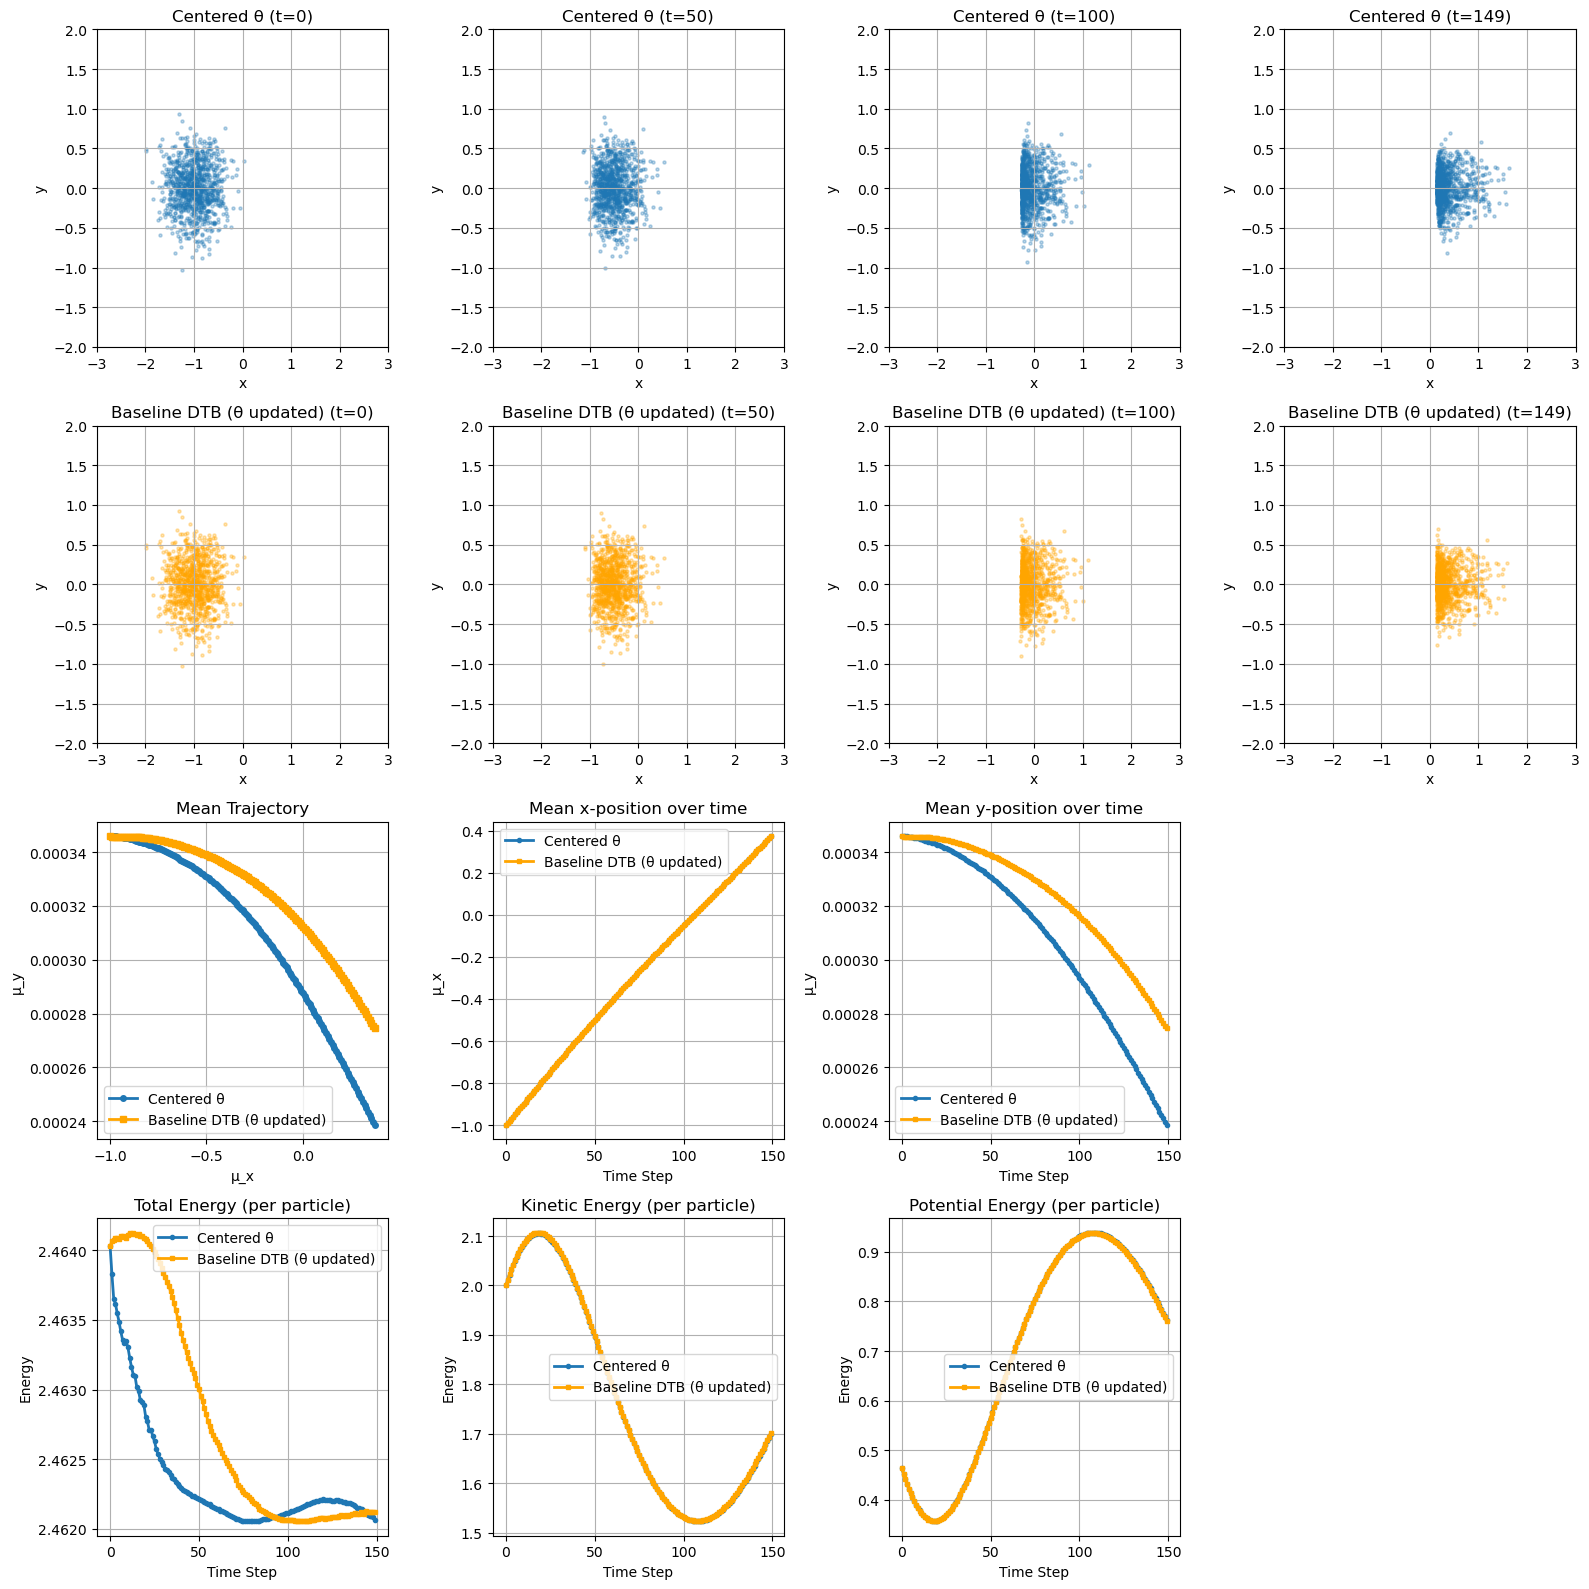

Creating animation...
Animation saved to centered_vs_baseline.gif


In [35]:
print("\nPlotting results...")
plot_comparison(fixed_metrics, baseline_metrics, label1="Centered θ", label2="Baseline DTB (θ updated)")

print("Creating animation...")
create_comparison_animation(fixed_metrics, baseline_metrics, potential, 'centered_vs_baseline.gif', 
                            fps=10, label1="Fixed θ", label2="Baseline DTB",xlim=(-2,2),ylim = (-1,1))


Comparing fixed θ with Exact Dynamics


Exact dynamics: 100%|██████████| 150/150 [00:00<00:00, 183.41it/s, KE=1.705, PE=0.759, Total=2.464]


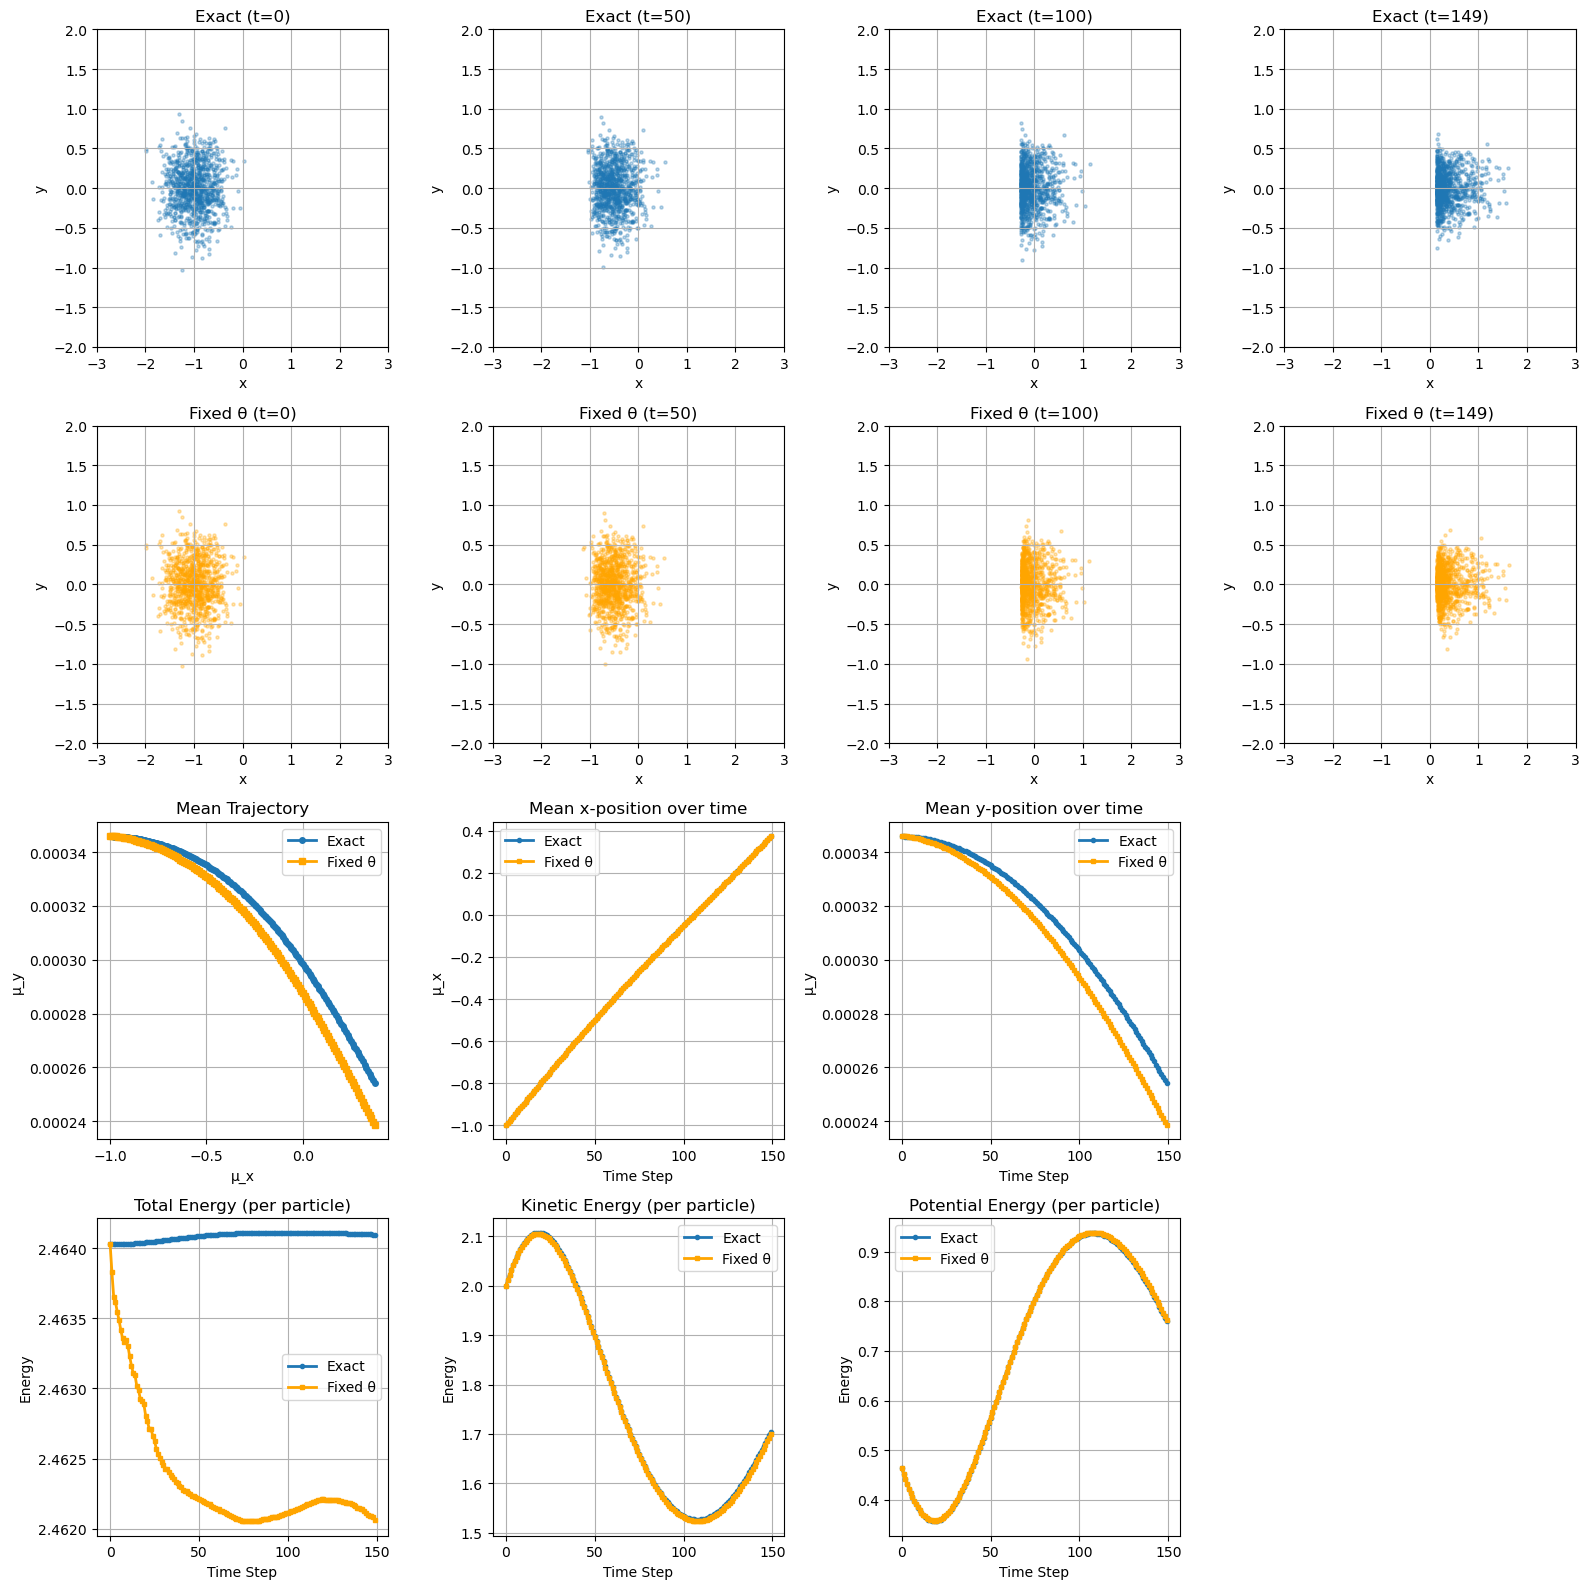


=== Comparison with Exact Dynamics ===
Initial position MSE: 0.000000
Final position MSE: 0.000976
Max position MSE: 0.000976

Initial total energy: 2.464028
Exact final energy: 2.464097
Approx final energy: 2.462061
Exact energy drift: 0.000069
Approx energy drift: 0.001967


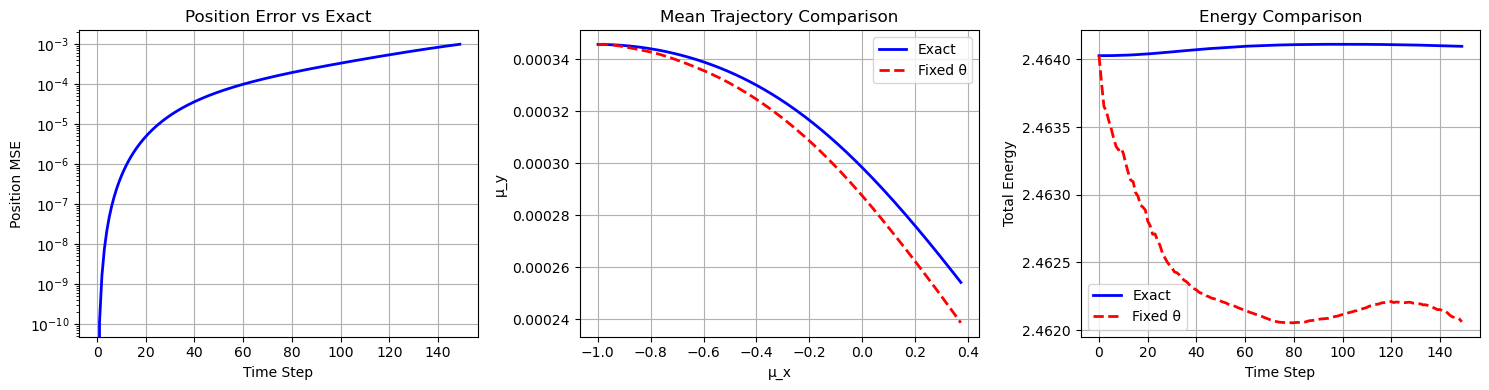


Comparing Baseline DTB with Exact Dynamics


Exact dynamics: 100%|██████████| 150/150 [00:00<00:00, 313.15it/s, KE=1.705, PE=0.759, Total=2.464]


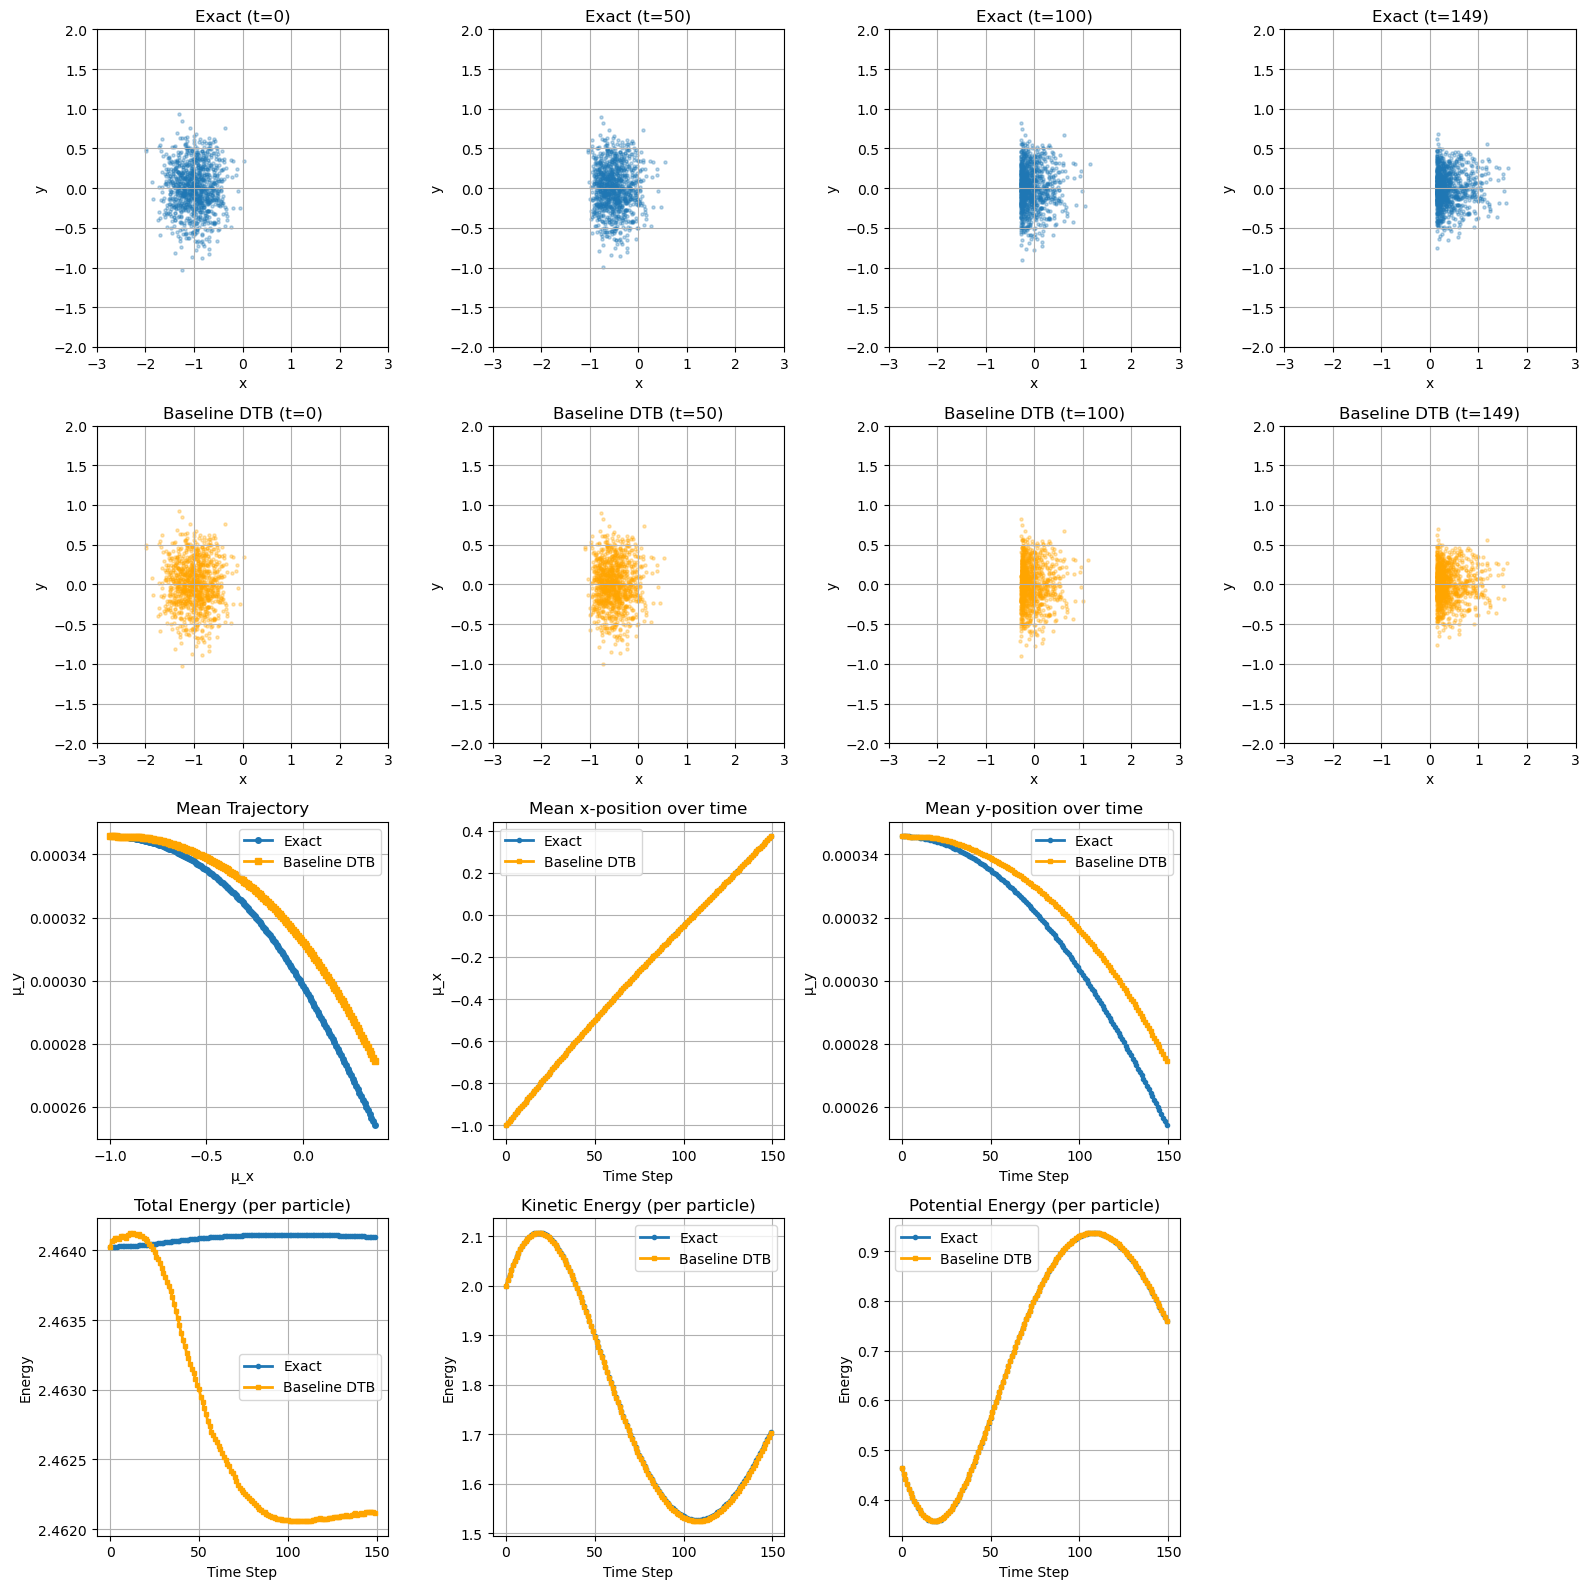


=== Comparison with Exact Dynamics ===
Initial position MSE: 0.000000
Final position MSE: 0.000230
Max position MSE: 0.000230

Initial total energy: 2.464028
Exact final energy: 2.464097
Approx final energy: 2.462117
Exact energy drift: 0.000069
Approx energy drift: 0.001911


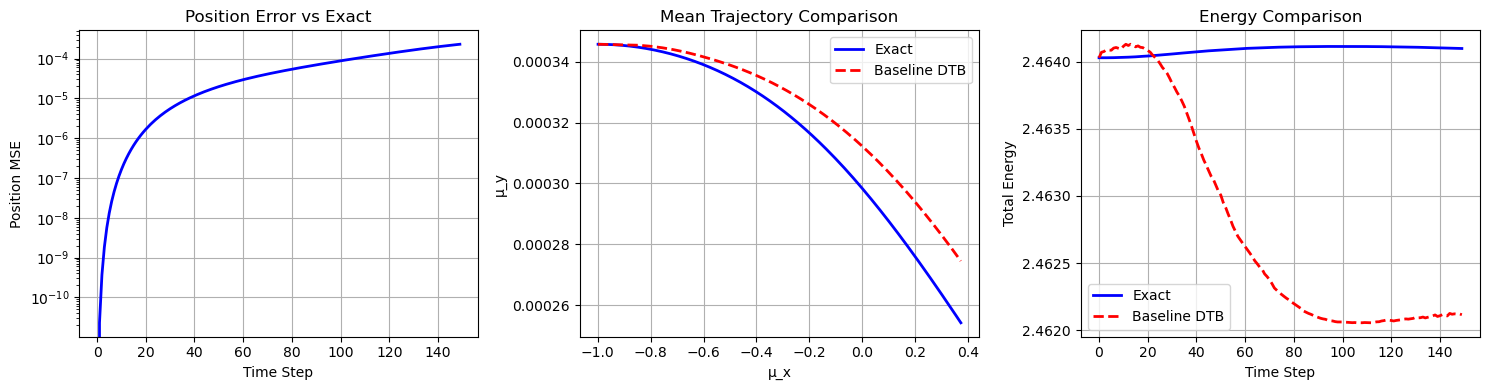

In [34]:
# Compare approximate solutions with exact dynamics
print("\n" + "="*60)
print("Comparing fixed θ with Exact Dynamics")
print("="*60)
exact_metrics = compare_with_exact(fixed_metrics, X0, Lambda0, potential, h, 
                                    approx_label="Fixed θ")

print("\n" + "="*60)
print("Comparing Baseline DTB with Exact Dynamics")  
print("="*60)
_ = compare_with_exact(baseline_metrics, X0, Lambda0, potential, h,
                       approx_label="Baseline DTB")